# Fine-Tune the System
___

 - You will want to use as much data as possible for this step, especially as you move toward the end of fine-tuning.
 - As always, automate what you can.
 - Fine-tune the hyperparameters using cross-validation:
 - Treat your data transformation choices as hyperparameters, especially when you are not sure about them (e.g., if you're not sure whether to replace missing values with zeros or with the median value, or to just drop the rows).
 - Unless there are very few hyperparameter values to explore, prefer random search over grid search. If training is very long, you may prefer a Bayesian optimization approach (e.g., using Gaussian process priors, as described by Jasper Snoek et al.).
 - Try Ensemble methods. Combining your best models will often produce better performance than running them individually.
 - Once you are confident about your final model, measure its performance on the test set to estimate the generalization error.
 - Warning : Don't tweak your model after measuring the generalization error: you would just start overfitting the test set.

___

Adding even more embedding dimensions - to 500.

___

In [1]:
# Import Libraries
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split


from keras.layers import Add, Activation, Lambda
from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.layers.embeddings import Embedding
from tensorflow.keras.optimizers import Adam

# from keras.optimizers import Adam
from keras.regularizers import l2

import math


# Set printing in non scientific notation
np.set_printoptions(suppress=True)


Data

In [2]:
combined_business_data = pd.read_pickle("combined_business_data.pkl")
combined_business_data.head(2) 

,user_id,business_id,stars,date,name,address,user,business
0,nOTl4aPC4tKHK35T3bNauQ,xVEtGucSRLk5pxxN0t4i6g,5.0,2012-08-23,"""Eiffel Tower""","""3655 Las Vegas Blvd S""",4189,1920
1,l0-VQ8nA_oijpKlRB7dkow,xVEtGucSRLk5pxxN0t4i6g,4.0,2010-02-11,"""Eiffel Tower""","""3655 Las Vegas Blvd S""",3989,1920


In [3]:
# Store counts of distinct users and restaurants into variables
n_users = combined_business_data["user"].nunique()
n_rests = combined_business_data["business"].nunique()

# Store min and max stars into a variable
min_rating = min(combined_business_data["stars"])
max_rating = max(combined_business_data["stars"])

print(n_users, n_rests, min_rating, max_rating)

5186 2004 1.0 5.0


In [4]:
# Store inputs into variabe X; store Output into variable y
X = combined_business_data[["user", "business"]].values
y = combined_business_data["stars"].values

print(X.shape, y.shape)

(11591, 2) (11591,)


Split

In [5]:
# Split data into Training and Validation set
X_train_keras, X_val_keras, y_train_keras, y_val_keras = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
)

print(X_train_keras.shape, X_val_keras.shape, y_train_keras.shape, y_val_keras.shape)

(9272, 2) (2319, 2) (9272,) (2319,)


In [6]:
# Storing Users and Restaurant into its own array. They will be input separately into the Keras Model
X_train_array = [X_train_keras[:, 0], X_train_keras[:, 1]]
X_val_array = [X_val_keras[:, 0], X_val_keras[:, 1]]

In [7]:
X_train_array

[array([3527, 3494,  763, ..., 4744, 1615, 2416]),
 array([ 166, 1511, 1972, ...,  480,  870,  918])]

In [8]:
X_val_array

[array([2068, 1672, 1196, ..., 4855, 2335, 4817]),
 array([ 118, 1293,  235, ...,  291,  974,  788])]

Choose number of dimensions in embedding space

In [9]:
# Variable that stores number of embedding dimension. Will be tuned as hyperparameter later.
n_embedding_dim = 500

## Model

Adding Bias

In [10]:
class EmbeddingLayer:
    '''
    Class to create main section of the model, creating embedding layer followed by the reshape layer.
    '''
    def __init__(self, n_items, n_embedding_dim):
        # ^ vocabulary size, number of categories, or here,
        # ^ number of distinct users or number of distinct restaurants
        self.n_items = n_items

        # ^ encode into how many dimensions?
        # ^ each item(user/restaurant) will be represented as a vector of size n_embedding_dim
        self.n_embedding_dim = n_embedding_dim

    def __call__(self, x):
        x = Embedding(
            input_dim = self.n_items, # number of users/restaurants in a training set
            output_dim = self.n_embedding_dim, # how many dimensions should embedding space contain
            embeddings_initializer="he_normal", # initializer for initial parameter values at the beggining of training
            embeddings_regularizer=l2(1e-6), # regularzation to reduce overfitting
        )(x)
        x = Reshape((self.n_embedding_dim,))(x)

        return x


def Recommender(n_users, n_rests, n_embedding_dim, min_rating, max_rating):
    user = Input(shape=(1,))
    u = EmbeddingLayer(n_users, n_embedding_dim)(user)
    ub = EmbeddingLayer(n_users, 1)(user)  # bias

    restaurant = Input(shape=(1,))
    m = EmbeddingLayer(n_rests, n_embedding_dim)(restaurant)
    mb = EmbeddingLayer(n_rests, 1)(restaurant)  # bias

    x = Dot(axes=1)([u, m]) # Dot product between vector of user and vector of restaurant
    x = Add()([x, ub, mb]) # Adding both bias vectors
    x = Activation("sigmoid")(x)
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x) # Scaling

    model = Model(inputs=[user, restaurant], outputs=x) # Creating the model and specifying input and output
    opt = Adam(learning_rate=0.001) # Optimizer algorithm and its learning rate
    model.compile(loss="mean_squared_error", optimizer=opt) # compiling model and specifying loss function

    return model

In [11]:
keras_model = Recommender(n_users, n_rests, n_embedding_dim, min_rating, max_rating)
keras_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 500)       2593000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 500)       1002000     input_2[0][0]                    
______________________________________________________________________________________________

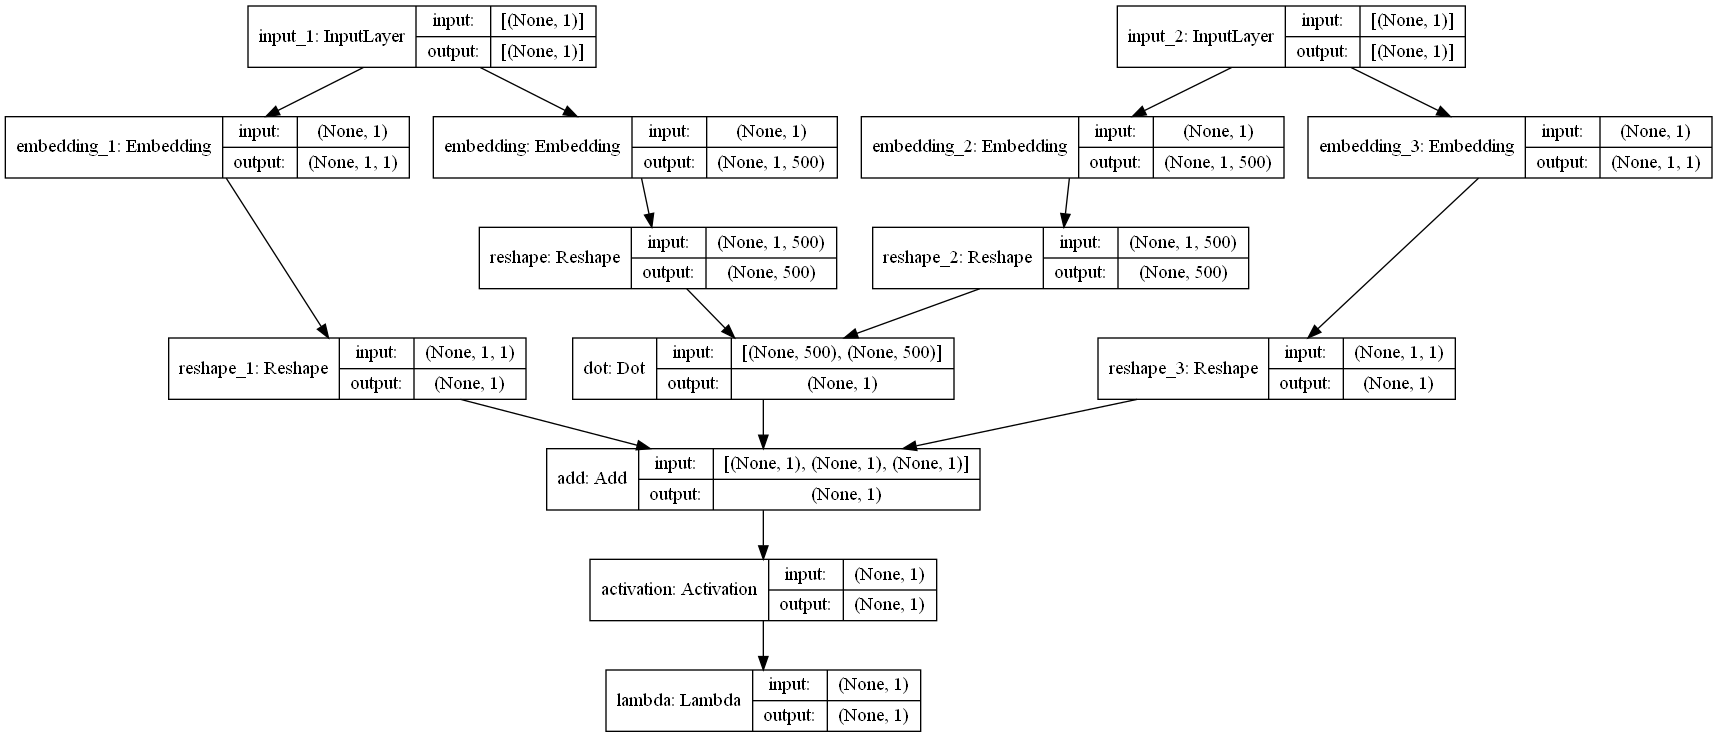

In [12]:
# Plot Model
from keras.utils.vis_utils import plot_model

plot_model(keras_model, show_shapes=True)


Fit / Train

In [13]:
# Fitting the model, choosing batch size, number of epochs, and test data for validation
history = keras_model.fit(
    x=X_train_array,
    y=y_train_keras,
    batch_size=64,
    epochs=20,
    verbose=1,
    validation_data=(
        X_val_array,
        y_val_keras,
    ),
)

Epoch 1/20
145/145 [==============================] - 8s 30ms/step - loss: 2.4197 - val_loss: 2.3621TA: 1s - loss: - ETA: 0s - lo
Epoch 2/20
145/145 [==============================] - 4s 25ms/step - loss: 1.9684 - val_loss: 2.3094
Epoch 3/20
145/145 [==============================] - 4s 29ms/step - loss: 1.2613 - val_loss: 2.2697.270 - ETA: 0s - loss: 1.
Epoch 4/20
145/145 [==============================] - 4s 26ms/step - loss: 0.5824 - val_loss: 2.2506
Epoch 5/20
145/145 [==============================] - 4s 25ms/step - loss: 0.2539 - val_loss: 2.2426
Epoch 6/20
145/145 [==============================] - 4s 24ms/step - loss: 0.1365 - val_loss: 2.2389
Epoch 7/20
145/145 [==============================] - 5s 34ms/step - loss: 0.0897 - val_loss: 2.2378s - loss: 0.
Epoch 8/20
145/145 [==============================] - 4s 28ms/step - loss: 0.0670 - val_loss: 2.2369
Epoch 9/20
145/145 [==============================] - 5s 35ms/step - loss: 0.0552 - val_loss: 2.2362 - loss: 0.05  - ETA: 0s -

Evaluation

In [14]:
mse_test = keras_model.evaluate(X_val_array, y_val_keras)
print(f"MSE:\n {mse_test}")

73/73 [==============================] - 1s 8ms/step - loss: 2.2284
MSE:
 2.228423833847046


Prediction

In [15]:
# prediction
predictions = keras_model.predict(X_val_array)
predictions[0:2]

array([[3.0854082],
       [3.0420718]], dtype=float32)

Examine Predictions

In [16]:
# create table adding prediction results as a column
df_test = pd.DataFrame(X_val_keras[:,0])
df_test.rename(columns={0: "user"}, inplace=True)
df_test['business'] = X_val_keras[:,1]
df_test['stars'] = y_val_keras
df_test["predictions"] = predictions
df_test.head()

,user,business,stars,predictions
0,2068,118,4.0,3.085408
1,1672,1293,5.0,3.042072
2,1196,235,3.0,3.025687
3,3377,744,3.0,2.846114
4,2932,291,4.0,3.316103


In [17]:
# Change label colors of matplotlib
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'white'

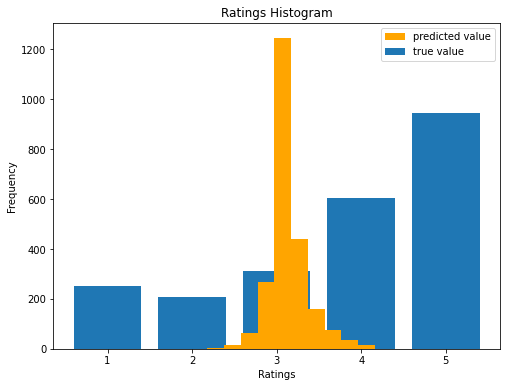

In [18]:
# Plotting the distribution of actual and predicted stars
import matplotlib.pyplot as plt
import seaborn as sns
values, counts = np.unique(df_test['stars'], return_counts=True)

plt.figure(figsize=(8,6))
plt.bar(values, counts, tick_label=['1','2','3','4','5'], label='true value')
plt.hist(predictions, color='orange', label='predicted value')
plt.xlabel("Ratings")
plt.ylabel("Frequency")
plt.title("Ratings Histogram")
plt.legend()
plt.show()

# For 2 Dimensional Embedding space all predictions are just around 3, which gives big error.

Learning Curves

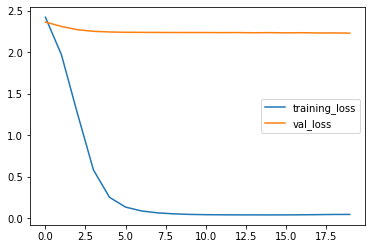

In [19]:
# Learning Curves
df = pd.DataFrame(history.history)

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(df.index, df["loss"], label="training_loss")
ax.plot(df.index, df["val_loss"], label="val_loss")
ax.legend()



Result

Adding embedding dimensions to 500 seems to even worsen the validation error.